In [29]:
import csv
from collections import defaultdict
from constants import *
import pandas as pd
from statsmodels.stats.proportion import proportion_confint 
import numpy as np  
import matplotlib.pyplot as plt

In [3]:
valid_users = set()
user_train_count = defaultdict(int)     # number of training grids completed for each user
user_test_count = defaultdict(int)      # number of test grids completed for each user
user_train_score = defaultdict(int)     # cumulative training score for each user
user_test_timeouts = defaultdict(set)   # test grids the user timed out on for each user

with open('data/insight_data_raw.csv', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['step'] == '6':          # step 6 contains metadata for the trial as a whole including total reward
            user = row['userid']
            valid_users.add(user)
            if row['type'] == "train":
                user_train_count[user] += 1
                user_train_score[user] += int(row['reward_cum'])
            elif row['type'] == "test":
                user_test_count[user] += 1
               
# exclude users who did not complete all training and test grids, scored less than 0 points in training
def include_user(user):
    return not (user_train_count[user]!=60 or user_test_count[user]!=50 or user_train_score[user]<0)

print("Number of users before exclusions: " + str(len(valid_users)))       
valid_users = set(filter(include_user, valid_users))
print("Number of users after exclusions: " + str(len(valid_users)))

Number of users before exclusions: 364
Number of users after exclusions: 255


In [112]:
df = pd.read_csv('data/insight_data_raw.csv', encoding='utf-8-sig') 
df['userid'] = df['userid'].apply(str)
filtered = df[(df['userid'].isin(valid_users))]
filtered.to_csv('data/insight_data_after_exclusions.csv')
filtered = filtered[(filtered['step']==6) & (filtered['type']=='train')]
filtered['correct'] = filtered['reward_cum'] == filtered['reward_max']
training_accuracy = filtered.groupby('userid')['correct'].mean()
mean_training_accuracy = training_accuracy.mean()
sem_training_accuracy = training_accuracy.sem()
print(f"Mean training accuracy: {mean_training_accuracy:.1%}")
print(f"SEM training accuracy: {sem_training_accuracy:.1%}")

Mean training accuracy: 77.3%
SEM training accuracy: 0.5%


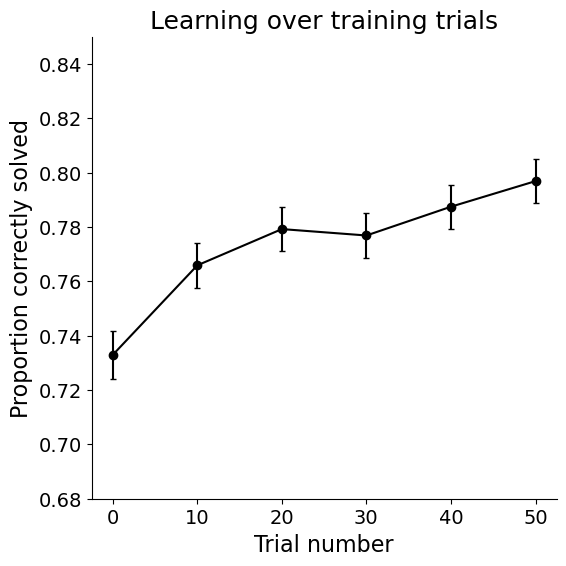

In [113]:
# Group every 5 trials to smooth the graph
plt.rcParams.update({'font.size': 14, 'figure.figsize': (6, 6), 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14, 'legend.title_fontsize': 16})
# Calculate mean and standard error of the mean for each trial group
filtered['trial_group'] = (filtered['trialnum'] - 1) // 10
mean_correct_grouped = filtered.groupby('trial_group')['correct'].mean()
sem_correct_grouped = filtered.groupby('trial_group')['correct'].sem()

# Plot the average correct over trial groups with error bars
plt.errorbar(mean_correct_grouped.index * 10, mean_correct_grouped, yerr=sem_correct_grouped, marker='o', color='black',capsize=2)
plt.xlabel('Trial number')
plt.ylabel('Proportion correctly solved')
plt.ylim(.68,.85)
plt.title('Learning over training trials')

# Remove grid background and top and right spines
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [5]:
def label(x):
    if x < 100: return "filler"
    if 100 < x < 200: return "Push"
    if 200 < x < 300: return "Switch"
    if 300 < x < 400: return "Switch Control"
    if 400 < x: return "Push Control"
test = df[(df['userid'].isin(valid_users)) & (df['step']==6) & (df['type']=='test')].copy()
test['gridtype'] = test['gridnum'].apply(label)
test['trial'] = test.groupby(['gridtype','userid']).cumcount()+1
test['score_dif'] = test['reward_cum'] - test['reward_max'] + 1
test['userid'] = test['userid'].astype(int)
push = test[(test['gridtype'] == 'Push')][['trial','score_dif', 'userid', 'gridtype','gridnum']]
push.to_csv('data/insight_push_data_coded.csv')
switch = test[(test['gridtype'] == 'Switch')][['trial','score_dif', 'userid', 'gridtype','gridnum']]
switch.to_csv('data/insight_switch_data_coded.csv')

In [6]:
from scipy.stats import sem

test.loc[:, 'correct'] = test['reward_cum'] == test['reward_max']

def get_mean_ci(gridtype):
    mean = test.loc[test['gridtype']==gridtype]['correct'].mean()
    sem_value = sem(test.loc[test['gridtype']==gridtype]['correct'])
    print(gridtype + ": " + '{:.1%}'.format(mean) + " ± " + '{:.1%}'.format(sem_value))

get_mean_ci('Push')
get_mean_ci('Switch')
get_mean_ci('Push Control')
get_mean_ci('Switch Control')

Push: 62.5% ± 1.1%
Switch: 94.5% ± 0.5%
Push Control: 94.0% ± 0.5%
Switch Control: 96.0% ± 0.4%


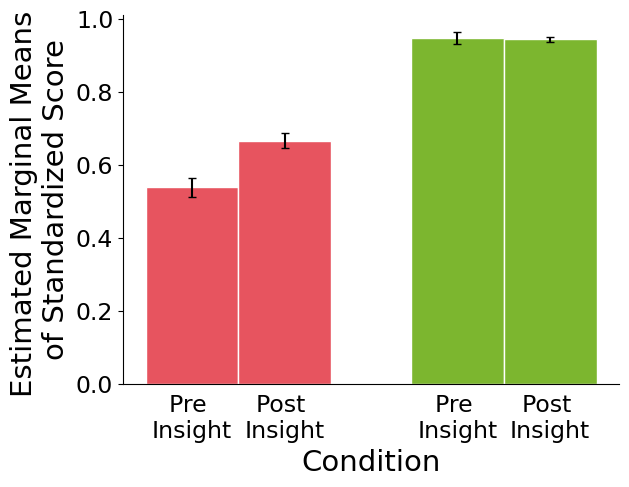

In [30]:
# figure data read out from emmean R analysis
emmean = pd.read_csv('data/fig3A_emmeans.csv')
labels = ['Pre \nInsight','Post \nInsight','Pre \nInsight','Post \nInsight']
pre_insight_proportions = [emmean.iloc[0]['emmean'],emmean.iloc[2]['emmean']]
pre_insight_err = [emmean.iloc[0]['SE'], emmean.iloc[2]['SE']]
post_insight_proportions = [emmean.iloc[1]['emmean'],emmean.iloc[3]['emmean']]
post_insight_err = [emmean.iloc[1]['SE'],emmean.iloc[3]['SE']]

x = np.array([0,1])
width = 0.35  # the width of the bars
color=['#E7545F', '#7CB62F']
plt.rcParams.update({'font.size': 21})

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pre_insight_proportions, width, yerr=pre_insight_err, capsize=3, color=color, edgecolor='white')
rects2 = ax.bar(x + width/2, post_insight_proportions, width, yerr=post_insight_err, capsize=3, color=color,  edgecolor='white')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Estimated Marginal Means \nof Standardized Score')
ax.set_xticks(np.array([-.175,0.175,.825,1.175]))
ax.set_xticklabels(labels)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
ax.set_xlabel('Condition')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.tick_params(
    axis='both',         
    which='both',     
    bottom=False)
plt.show()

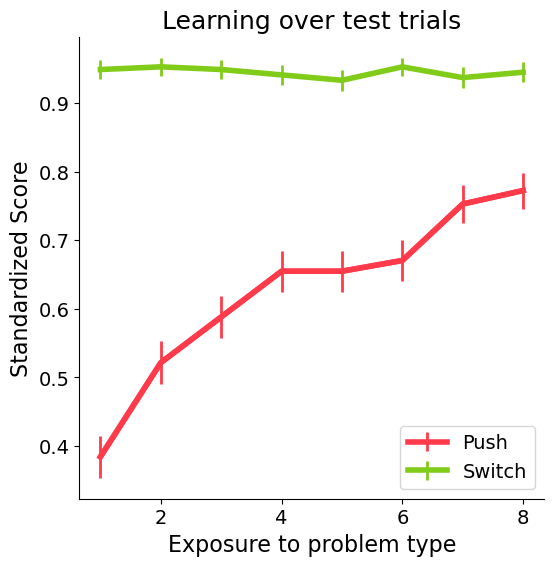

In [109]:
push.groupby('trial')['score_dif'].mean().plot(linewidth=4, color="#FF3B4B", label='_nolegend_')
push_mean = push.groupby('trial')['score_dif'].mean()
push_sem = push.groupby('trial')['score_dif'].sem()
switch_mean = switch.groupby('trial')['score_dif'].mean()
switch_sem = switch.groupby('trial')['score_dif'].sem()

plt.rcParams.update({'font.size': 14, 'figure.figsize': (6, 6), 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'legend.fontsize': 14, 'legend.title_fontsize': 16})
plt.errorbar(push_mean.index, push_mean, yerr=push_sem, linewidth=4, elinewidth=2, color="#FF3B4B", label='Push')
plt.errorbar(switch_mean.index, switch_mean, yerr=switch_sem, linewidth=4, elinewidth=2, color="#81CC18", label='Switch')

plt.xlabel('Exposure to problem type')
plt.ylabel('Standardized Score')
plt.title('Learning over test trials')
plt.legend()
plt.gcf().set_size_inches(6,6)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()